In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.special import logsumexp

## Predicciones con exceso de confianza (ejemplo 20.4).

Primeramente, creamos el conjunto de datos

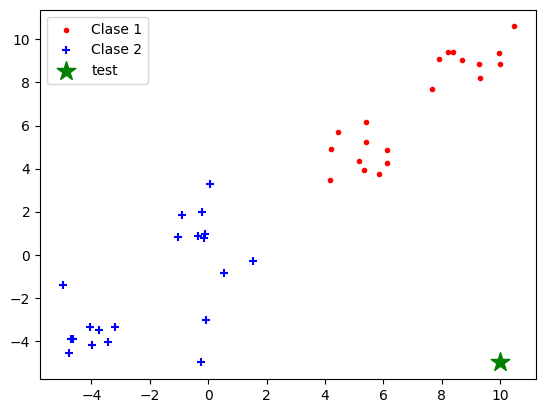

In [ ]:
# La dimensión de los datos es 2.
D = 2
N = 10

# Datos de la clase 1.
X1_part1 = np.random.randn(D, N)
X1_part2 = np.random.randn(D, N) + np.array([[4], [4]])
X1 = np.hstack((X1_part1, X1_part2))
X1 = X1 + 5  # Desplazar todos los elementos en 5 unidades.

# Datos de la clase 2.
X2_part1 = np.random.randn(D, N)
X2_part2 = np.random.randn(D, N) - np.array([[4], [4]])
X2 = np.hstack((X2_part1, X2_part2))

Xtest = np.hstack((X1, X2, np.array([[10], [-5]])))

# Dibujar datos.
plt.figure()
plt.scatter(X1[0, :], X1[1, :], c='red', marker='.', label='Clase 1')
plt.scatter(X2[0, :], X2[1, :], c='blue', marker='+', label='Clase 2')
plt.scatter(Xtest[0, -1], Xtest[1, -1], c='green', marker='*', s=200, label='test')

plt.legend()
plt.show()

Creamos dos GMM con dos componentes cada una y las entrenamos para que ajusten a los datos X1 y X2.

In [ ]:
gmm1 = GaussianMixture(n_components=2).fit(X1.T)
gmm2 = GaussianMixture(n_components=2).fit(X2.T)

Calculamos la probabilidad de cada una de las clases dado el punto de test ([-10,-5]). Para ello utilizamos la fórmula (20.3.22): $p(c| x^*) \propto p(x^*| c)p(c)$.
- $p(c)$ es la probabilidad a priori de cada clase, que es proporcional al número de puntos de entrenamiento que contiene.
- $p(x^*| c)$ es la función de densidad de la mixtura de gaussianas asociada a la clase $c$. En este caso, puesto que las mezclas contienen solo dos componentes:
$$
p(x| c) = p(h=1) \mathcal{N}(x|m_1^c,S_1^c) + p(h=2) \mathcal{N}(x|m_2^c,S_2^c)
$$
En el código de abajo trabajamos con verosimilitudes logarítmicas, aprovechando que la clase GaussianMixture la calcula por nosotros.

Probabilidades de las clases:
 para el último punto hay exceso de confianza en la clasificación


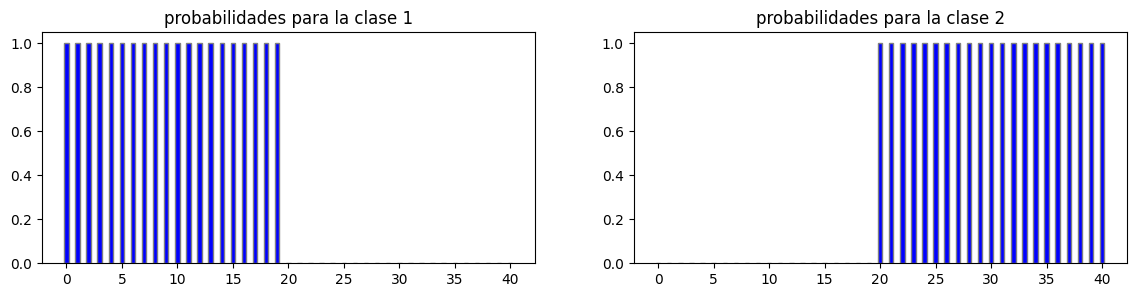

In [ ]:
# score_samples devuelve la (log) verosimilitud de cada uno de los puntos en el argumento.
logl1 = gmm1.score_samples(Xtest.T)
logl2 = gmm2.score_samples(Xtest.T)

p1 = X1.shape[1] / (X1.shape[1] + X2.shape[1]) # probabilidades a priori (proporcionales al número de elementos en cada clase)
p2 = X2.shape[1] / (X1.shape[1] + X2.shape[1])

print('Probabilidades de las clases:\n para el último punto hay exceso de confianza en la clasificación')
logs = np.array([logl1 + np.log(p1), logl2 + np.log(p2)])
posteriorc = np.exp(logs - logs.max(axis=0))
posteriorc = posteriorc / posteriorc.sum(axis=0)  # probabilidad posterior de las clases dada cada muestra

# Dibujar gráficos de barras para representar las probabilidades.
fig, axes = plt.subplots(1, 2, figsize=(14, 3))
axes[0].bar(np.arange(41), posteriorc[0,:], color ='b', width = 0.4, edgecolor ='grey')
axes[0].set_title('probabilidades para la clase 1')
axes[1].bar(np.arange(41), posteriorc[1,:], color ='b', width = 0.4, edgecolor ='grey')
axes[1].set_title('probabilidades para la clase 2')

plt.show()

Como se explica en el libro, para tratar de solventar la dificultad encontrada vamos a añadir una componente adicional en cada una de las mixturas con baja probabilidad pero covarianza amplia. Para puntos alejados de los datos de entrenamiento, esta componente es la que tendrá más peso y, al ser igual en las dos mixturas, conseguirá que la probabilidad asignada a cada clase sea aproximadamente la misma.

Nótese que ahora realmente no se vuelven a entrenar las mixturas sino que tan solo se utilizan para recalcular las probabilidades. Esto implica que no podemos utilizar la clase GaussianMixture como en el caso anterior y necesitamos definir una función que, dadas las medias, covarianzas y pesos de una mixtura de gaussianas, devuelva la verosimilitud (o la log-verosimilitud) de los puntos que se pasen como argumento.

In [ ]:
from scipy.stats import multivariate_normal

def likelihoods(X, means, covariances, weights):
    """
    Devuelve la verosimilitud de cada punto X en la mixtura gaussiana.
    """
    n_components = len(weights)
    n_samples = X.shape[0]

    # Inicializar un array para almacenar las verosimilitudes de cada muestra
    likelihoods = np.zeros(n_samples)

    for k in range(n_components):
        # Crear la distribución normal multidimensional de la componente
        rv = multivariate_normal(mean=means[k], cov=covariances[k])

        # Añadir la verosimilitud ponderada
        likelihoods += weights[k] * rv.pdf(X)

    return likelihoods

Probabilidades de las clases:
 el último tiene ahora la misma probabilidad en ambas clases


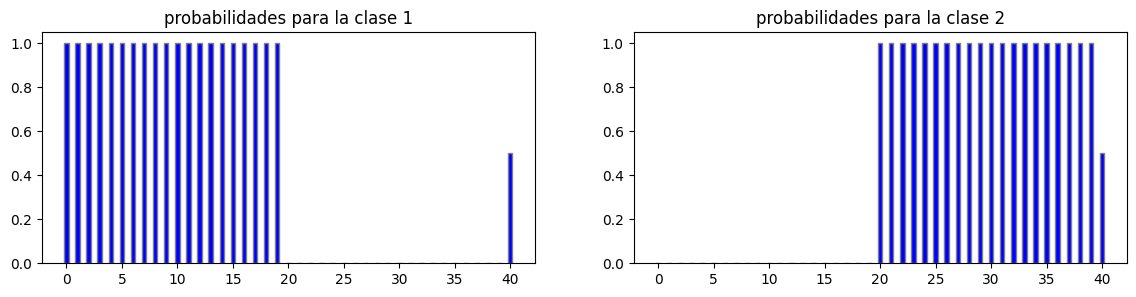

In [ ]:
# Componente adicional con gran varianza y baja probabilidad.
smallprob = 0.0001
var = 10

# Calculamos los nuevos pesos, medias y covarianzas de la primera mixtura.
P1_ext = (np.concatenate((gmm1.weights_, [smallprob]))) / (gmm1.weights_.sum() + smallprob)
m1_ext = m1_ext = np.concatenate((gmm1.means_, [[0, 0]]))
S1_ext = np.concatenate((gmm1.covariances_, [np.eye(D) * var]))

# Calculamos los nuevos pesos, medias y covarianzas de la segunda mixtura.
P2_ext = (np.concatenate((gmm2.weights_, [smallprob]))) / (gmm2.weights_.sum() + smallprob)
m2_ext = m2_ext = np.concatenate((gmm2.means_, [[0, 0]]))
S2_ext = np.concatenate((gmm2.covariances_, [np.eye(D) * var]))

# Recalculamos las verosimilitudes de los puntos.
lik1 = likelihoods(Xtest.T, m1_ext, S1_ext, P1_ext)
lik2 = likelihoods(Xtest.T, m2_ext, S2_ext, P2_ext)

print('Probabilidades de las clases:\n el último tiene ahora la misma probabilidad en ambas clases')
liks = np.vstack((lik1, lik2))
posteriorc2 = liks / liks.sum(axis=0) # probabilidades a posteriori

fig, axes = plt.subplots(1, 2, figsize=(14, 3))
axes[0].bar(np.arange(41), posteriorc2[0,:], color ='b', width = 0.4, edgecolor ='grey')
axes[0].set_title('probabilidades para la clase 1')
axes[1].bar(np.arange(41), posteriorc2[1,:], color ='b', width = 0.4, edgecolor ='grey')
axes[1].set_title('probabilidades para la clase 2')
plt.show()

## Cuestiones
Analizar los resultados obtenidos.

###Análisis de los resultados:

####Clasificación inicial:

En un primer lugar, la primera mitad de los puntos se ajustan de fomra segura la Clase 1, mientras que la segunda mitad se ajusta a la Clase 2.

####Clasificación después de agregar un nuevo componente:

Al agregar un componente adicional a ambas mezclas, el modelo se vuelve más flexible y puede capturar una mayor variedad de patrones en los datos.
Esto resulta en que las probabilidades para el punto 41 se vuelven equilibradas (0.5000 para ambas clases), lo que indica que ahora el modelo tiene dudas sobre a qué clase pertenece.

####Cambios en el resultado del último punto:
El último punto (41) cambia de una clasificación muy clara (probabilidades extremas) a una clasificación más ambigua (0.5000 para ambas clases) tras la adición de un nuevo componente de baja probabilidad. Esto se debe a que el nuevo componente proporciona una alternativa para el modelo, permitiendo que los datos que estaban previamente mal clasificados ahora tengan un soporte probabilístico mejor equilibrado.

####Conclusiones:
La inclusión de un nuevo componente en el modelo de mezcla gaussiana ha hecho que el clasificador sea más sensible y capaz de capturar variaciones en los datos que previamente se ignoraban.
El resultado es que, en situaciones donde los puntos de datos están muy cerca de la frontera entre clases, se logra un balance en las probabilidades.